In [1]:
#!/usr/bin/env python3
from rosbags.rosbag1 import Reader
from rosbags.serde import deserialize_cdr, ros1_to_cdr
from rosbags.typesys import get_types_from_msg, register_types
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Unpack ROSBag

In [2]:
add_types = {}
msg_text = Path('/home/eurus/Documents/College/Sem_4/ENAE788M/proj/ws/src/Project_Catch/vicon_bridge/msg/Marker.msg').read_text()
add_types.update(get_types_from_msg(msg_text, 'vicon_bridge/Marker'))
register_types(add_types)
msg_text = Path('/home/eurus/Documents/College/Sem_4/ENAE788M/proj/ws/src/Project_Catch/vicon_bridge/msg/Markers.msg').read_text()
add_types.update(get_types_from_msg(msg_text, 'vicon_bridge/Markers'))
register_types(add_types)

In [3]:
t_count = 0
marker_pos = {t_count:[]}
prev_t = False
# with Reader('/home/eurus/Documents/College/Sem_4/ENAE788M/proj/ws/src/Project_Catch/misc/marker_throw/throw_1.bag') as reader:
with Reader('/home/eurus/Documents/College/Sem_4/ENAE788M/proj/ws/src/Project_Catch/misc/marker_throw/throw_2.bag') as reader:
    for connection, timestamp, rawdata in reader.messages():
        ## The local position message from the PX4
        if connection.topic == '/vicon/markers':
            msg = deserialize_cdr(ros1_to_cdr(rawdata, connection.msgtype), connection.msgtype)
            if(len(msg.markers)):
                prev_t = True
                if(t_count not in marker_pos):
                    marker_pos[t_count] = []
                marker_pos[t_count].append([msg.markers[0].translation.x, msg.markers[0].translation.y, msg.markers[0].translation.z,msg.header.stamp.sec+msg.header.stamp.nanosec*1e-9])
            else:
                if(prev_t):
                    prev_t = False
                    if(len(marker_pos[t_count])<50):
                        marker_pos[t_count] = []
                    else:
                        marker_pos[t_count] = np.array(marker_pos[t_count])
                        t_count += 1
                    

In [4]:
throw_ = 1
marker_pos[throw_][1:,-1] -= marker_pos[throw_][:-1,-1]
marker_pos[throw_][0,-1] = 0

In [5]:
# for i in range(0, len(marker_pos)):
#     marker_ = np.array(marker_pos[i])
#     marker_[:,-1] = marker_[:,-1] - marker_[0,-1]
#     plt.scatter(marker_[:,-1], marker_[:,2])
#     plt.title('Marker Z Position vs Time Index: '+str(i))
#     plt.pause(0.1)

# Kalman Filter 3D parabola fit

In [6]:
class KalmanFilter3D:
    def __init__(self, g = 9.81):
        # Kalman Filter
        # State Vector
        ## x y z vx vy vz 
        self.state = np.zeros((6,1))
        
        # Input Vector
        ## Acceleration
        ## ax ay az
        self.u = np.zeros((3,1))
        
        # Observation Matrix
        ## Defines which states are measured
        ## Only position is measured, x y z az
        self.H = np.array([[1,0,0,0,0,0],
                           [0,1,0,0,0,0],
                           [0,0,1,0,0,0],
                    ])


        # Covariance Matrix
        ## Defines how much we trust the model 
        self.R = np.array([[0.001,0,0],
                           [0,0.001,0],
                           [0,0,0.001]
                    ])


        # Process Noise Covariance Matrix
        ## Defines the noise relationship between states
        self.Q = np.array([[0.01,0,0,0,0,0],
                           [0,0.01,0,0,0,0],
                           [0,0,0.01,0,0,0],
                           [0,0,0,0.01,0,0],
                           [0,0,0,0,0.01,0],
                           [0,0,0,0,0,0.01]
                    ])

        self.state_est = np.ones((6,1))
        self.P = np.eye(6)
        
        # Gravity along the Z axis
        self.gravity = -g
        
    def update(self, dt, measurement):
        
        # State Prediction
        self.state_predict(dt)
        
        # Measurement Update
        
        # Update the Kalman Gain
        ## Update the Kalman Gain based on the covariance and measurement matrix
        self.K = np.dot(self.P_est, np.dot(self.H.T, np.linalg.inv(self.H @ self.P_est @ self.H.T + self.R)))
        
        measurement = measurement.reshape(3,1)
        # Update the state estimation using the Kalman Gain
        self.state_est = self.state + np.dot(self.K, measurement - self.H @ self.state)
        
        # Update the covariance matrix
        self.P = np.dot((np.eye(6) - np.dot(self.K, self.H)), self.P_est)
        
    
    def state_predict(self, dt):
        #######
        # State Transition Matrix
        ## Defines states are dependent on previous states
        ## The lines are equation of motion s = s0 + v0*t + 0.5*a*t^2
        A = np.array([[1,0,0,dt,0,0],
                      [0,1,0,0,dt,0],
                      [0,0,1,0,0,dt],
                      [0,0,0,1,0,0],
                      [0,0,0,0,1,0],
                      [0,0,0,0,0,1]
                    ])
        B = np.array([[0.5*dt**2,0,0],
                      [0,0.5*dt**2,0],
                      [0,0,0.5*dt**2],
                      [dt,0,0],
                      [0,dt,0],
                      [0,0,dt],
                    ])
        self.u = np.array([[0],[0],[self.gravity]])
        ########
        
        # State Update
        ## Predict next state based on state transition matrix
        self.state = np.dot(A,self.state_est) + np.dot(B,self.u)
        
        # Covariance Update
        ## Update the covariance of the model based on the previous state and process noise
        self.P_est = np.dot(np.dot(A,self.P),A.T) + self.Q

        

# Test Filter

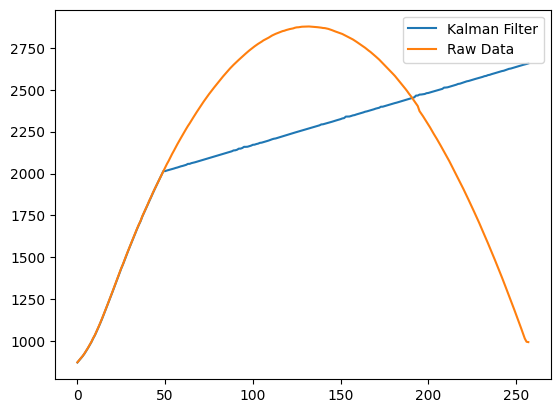

In [9]:
# Create a Kalman Filter
ekf = KalmanFilter3D()
kalman_states = []
error = []
lim = 50

## Estimate the state using the Kalman Filter on the marker position
for wp, marker_ in enumerate(marker_pos[throw_][:,:]):
    # print(marker_)
    if( wp<lim):
        ekf.update(marker_[-1], marker_[:3])
        kalman_states.append((ekf.state_est.reshape(6)))
        error.append(np.linalg.norm(marker_[:3]-ekf.state_est[:3].reshape(3)))
    else:
        ekf.state_predict(marker_[-1])
        kalman_states.append((ekf.state_est.reshape(6)))
        ekf.state_est = ekf.state
        ekf.P = ekf.P_est
        
kalman_states =np.array(kalman_states)
error = np.array(error)

## Plot the trajectory of the marker and the Kalman Filter estimate of the marker position in the Z axis
axis = 2
plt.plot(kalman_states[:,axis])
plt.plot(marker_pos[throw_][:,axis])
plt.legend(['Kalman Filter', 'Raw Data'])

In [8]:
marker_pos[throw_][:,:-1]

array([[ 1.59261787e+03, -2.91251383e+03,  8.74114086e+02],
       [ 1.58923951e+03, -2.89367058e+03,  8.86743471e+02],
       [ 1.58745195e+03, -2.87363397e+03,  8.98808349e+02],
       [ 1.58549507e+03, -2.85354452e+03,  9.11959065e+02],
       [ 1.58418265e+03, -2.83351532e+03,  9.26641993e+02],
       [ 1.58284674e+03, -2.81294107e+03,  9.43103446e+02],
       [ 1.58152253e+03, -2.79271534e+03,  9.60111064e+02],
       [ 1.58140119e+03, -2.77214746e+03,  9.79129725e+02],
       [ 1.58009750e+03, -2.75237337e+03,  9.96777955e+02],
       [ 1.57989435e+03, -2.73213505e+03,  1.01894806e+03],
       [ 1.57506653e+03, -2.71510632e+03,  1.03766102e+03],
       [ 1.57752035e+03, -2.69487637e+03,  1.06092551e+03],
       [ 1.57725584e+03, -2.67693186e+03,  1.08453651e+03],
       [ 1.57654167e+03, -2.65963836e+03,  1.10866399e+03],
       [ 1.57658270e+03, -2.64329207e+03,  1.13387069e+03],
       [ 1.57577127e+03, -2.62749900e+03,  1.16073912e+03],
       [ 1.57434218e+03, -2.61274325e+03